### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the data

In [2]:
fdate = '2015-03-02'
df = pd.read_csv(fdate + '.csv', parse_dates=['created_at'])
df.head()

,created_at,id,actor.login,org.login,repo.name,type
0,2015-03-02,2615962109,pdgago,simbiotica,simbiotica/charicharts,CreateEvent
1,2015-03-02,2615962111,micmania1,NaN,micmania1/silverstripe-cms,PushEvent
2,2015-03-02,2615962112,xsb,bitpay,bitpay/insight-api,WatchEvent
3,2015-03-02,2615962113,dkorolev,KnowSheet,KnowSheet/Bricks,PullRequestReviewCommentEvent
4,2015-03-02,2615962114,edwin-pers,NaN,edwin-pers/neuromancer,PushEvent


In [3]:
df.shape

(640631, 6)

In [4]:
df['type'].unique()

array(['CreateEvent', 'PushEvent', 'WatchEvent',
       'PullRequestReviewCommentEvent', 'IssueCommentEvent',
       'PullRequestEvent', 'DeleteEvent', 'CommitCommentEvent',
       'ForkEvent', 'IssuesEvent', 'GollumEvent', 'MemberEvent',
       'ReleaseEvent', 'PublicEvent'], dtype=object)

### Transform to triplets (actor, organization, repository), remove `WatchEvent` events , drop duplicates and missing values

In [5]:
df = df[(df['type']!='WatchEvent')]
df = df[['actor.login', 'org.login', 'repo.name']]
df = df.drop_duplicates()
df = df[df['org.login'].notnull()]
df.head()

,actor.login,org.login,repo.name
0,pdgago,simbiotica,simbiotica/charicharts
3,dkorolev,KnowSheet,KnowSheet/Bricks
5,dmolsen,pattern-lab,pattern-lab/patternengine-php-twig
7,LordSputnik,BookBrainz,BookBrainz/bookbrainz.org
16,ScottNZ,OpenRA,OpenRA/OpenRA


### Focus on the most frequently observed organisations (top 100)

In [6]:
org_actor_df = df.groupby(['org.login','actor.login']).agg('count').reset_index()
toporgs = org_actor_df.groupby(['org.login'])['org.login'].agg('count')
toporgs = toporgs.sort_values(ascending=False)[:100].keys().tolist()
toporgs[:10]

['mozilla',
 'apache',
 'facebook',
 'google',
 'angular',
 'docker',
 'elasticsearch',
 'iojs',
 'dotnet',
 'owncloud']

### Create all pairs of organisations present in each user initiated event

In [7]:
from itertools import combinations

actor_df = df.groupby('actor.login')
dfs = pd.DataFrame(columns=['Actor', 'Org1', 'Org2'])
for name, group in actor_df:
    orgs = group['org.login'].unique()
    orgs = [val for val in orgs if val in toporgs]
    if len(orgs)>1:
        actor_edge = pd.DataFrame(data=list(combinations(orgs, 2)), columns=['Org1', 'Org2'])
        actor_edge['Actor'] = name
        dfs = pd.concat([dfs, actor_edge])
dfs.head()

,Actor,Org1,Org2
0,1Power,mongodb,rails
0,AntouanK,iojs,npm
0,Carreau,ipython,JuliaLang
0,Dashed,babel,facebook
0,DavidA2014,atom,npm


### Get the weight edges

In [11]:
dfs = dfs.groupby(['Org1', 'Org2']).agg('count').reset_index().rename(columns={'Actor': 'weight'})
dfs = dfs.sort_values(by='weight', ascending=False)
dfs.head()

,Org1,Org2,weight
187,odoo-dev,odoo,17
186,odoo,odoo-dev,9
133,iojs,joyent,5
105,google,GoogleCloudPlatform,5
190,openshift,GoogleCloudPlatform,4


### Produce the `Graph` object of the network

In [12]:
import networkx as nx
G = nx.Graph()

for index, row in dfs.iterrows():
    G.add_edge(row['Org1'], row['Org2'], weight=row['weight'])

# remove isolated vertices (if any)    
remove = [node for node,degree in G.degree() if degree ==0]
G.remove_nodes_from(remove)

In [15]:
for node in G.nodes():
    print(node, G.nodes[node])

odoo-dev {}
odoo {}
iojs {}
joyent {}
google {}
GoogleCloudPlatform {}
openshift {}
chef {}
opscode-cookbooks {}
OCA {}
docker {}
babel {}
facebook {}
dart-lang {}
mozilla {}
driftyco {}
angular {}
twbs {}
yahoo {}
FortAwesome {}
atom {}
github {}
jquery {}
Polymer {}
mongodb {}
rails {}
Shopify {}
grpc {}
strongloop {}
golang {}
zurb {}
npm {}
cfpb {}
JuliaLang {}
mono {}
dotnet {}
aspnet {}
angular-ui {}
mozilla-b2g {}
w3c {}
ethereum {}
mapbox {}
rackerlabs {}
rust-lang {}
twitter {}
18F {}
paypal {}
ipython {}
jenkinsci {}
laravel {}
symfony {}
yiisoft {}
square {}
openhab {}
elasticsearch {}
apache {}
thoughtbot {}
gitlabhq {}
owncloud {}
nodeschool {}
saltstack {}
scikit-learn {}
edx {}
Automattic {}
balderdashy {}
hashicorp {}
ansible {}
Microsoft {}
ceph {}
JetBrains {}
alibaba {}
Homebrew {}
Netflix {}
spring-projects {}
Azure {}
coreos {}
CyanogenMod {}
WhisperSystems {}
puppetlabs {}


### Finally produce the plot

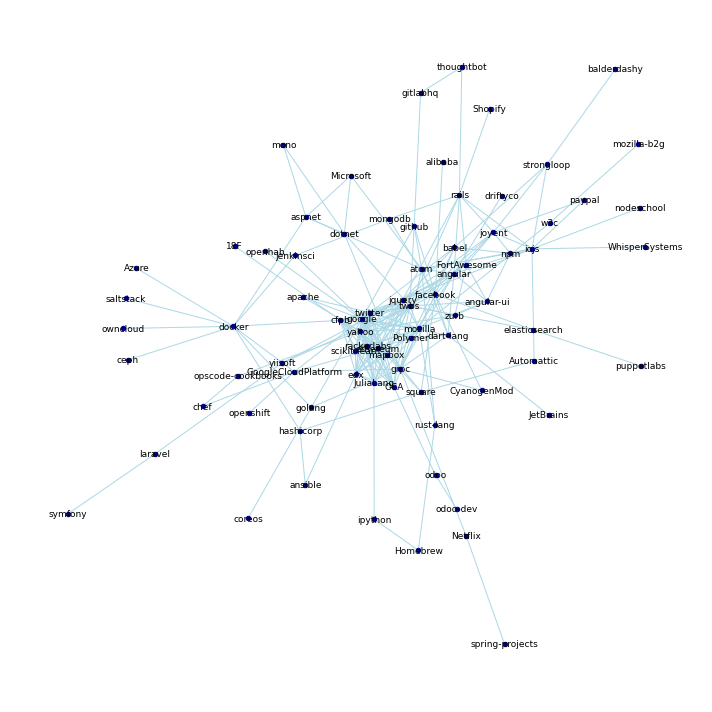

In [19]:
#Setting size and colours
options = {
     'node_color': 'darkblue',
     'edge_color': 'lightblue',
     'node_size': 20,
     'width': 1,
     'alpha': 1.0,
 }

# Producing the network
plt.subplots(figsize=(10,10))
pos=nx.spring_layout(G)
nx.draw(G,pos=pos,font_size=9,**options)
nx.draw_networkx_labels(G,pos=pos,font_size=9)
plt.tight_layout()
plt.axis('off');